# The TN Method

In [1]:
import itertools
import numpy as np
import sortednp as snp
import scipy.optimize
import cpd
import cpd._tn as tn
from numpy.linalg import norm, eigh

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'


np.set_printoptions(precision=3, linewidth=120)

%load_ext autoreload
%autoreload 2

In [2]:
# Generate input values.
n = 5
kappa = 1.5
np.random.seed(0)
#lam = np.sort(100 * (2 * np.random.random((n, )) - 1))
lam = np.sort(100 * np.random.random((n, )))
# print(lam)
# print(kappa)
# print(lam / kappa)
print(lam)

[42.365 54.488 54.881 60.276 71.519]


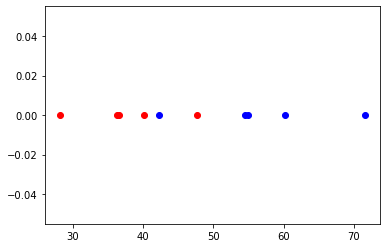

In [3]:
plt.scatter(lam, np.zeros((n, )), color="b")
plt.scatter(lam / kappa, np.zeros((n, )), color="r");

In [4]:
def _get_intervals(lam, kappa):
    """lam must be sorted."""
    a = [lam, lam / kappa]
    merged_endpoints, (i1, i2) = snp.merge(a[0], a[1], indices=True)
    merged_index = list(cpd._tn._merge_indices(i1, i2)) + [(0, len(lam))]
    # Right-pad so |one-past-last interval| = |last interval|.
    merged_endpoints = np.append(merged_endpoints, 2 * merged_endpoints[-1] - merged_endpoints[-2])

    limit, endpoint_prev = [-1, -1], -1  # limit = (l, u). Dummy negative number for 'endpoint_prev'.
    for ind, endpoint in zip(merged_index, merged_endpoints):
        if endpoint > 0:
            # Add 1 from u to match f's definition in terms of lam[l-1], lam[l]; lam[u-1] ,lam[u].
            yield (limit[0], limit[1] + 1), (max(0, endpoint_prev), endpoint)
        limit[ind[0]] = ind[1]
        endpoint_prev = endpoint
        

def _f(lam, kappa, l, u, mu, p: float):
    """Function of mu for mu >= 0. Piecewise quadratic on each interval of the indices (l, u)."""
    return sum((mu - lam[:l + 1]) ** p) + sum((lam[u:] - kappa * mu) ** p)


def _mu_minimizer_in_interval_direct(lam, kappa, endpoint_index, endpoint):
    """O(n^2) direct computation."""
    for (l, u), (mu_min, mu_max) in zip(endpoint_index, endpoint):
        if l == -1 and u == len(lam):
            yield 0
        else:
            mu = (sum(lam[:l + 1]) + kappa * sum(lam[u:])) / (l + 1 + kappa ** 2 * (len(lam) - u))
            yield min(max(mu, mu_min), mu_max)

def _global_mu_minimize_explicit_f(endpoint, endpoint_index, kappa, lam, p):
    """Explicit O(n^2) """
    mu_minimizer = np.array(list(_mu_minimizer_in_interval_direct(lam, kappa, endpoint_index, endpoint)))
    f_min = np.array([_f(lam, kappa, l, u, mu, p) for mu, (l, u) in zip(mu_minimizer, endpoint_index)])
    ind = np.argmin(f_min)
    return endpoint_index[ind][0], endpoint_index[ind][1], mu_minimizer[ind], f_min[ind]
   
def _global_mu_minimizer(lam, kappa, p):
    intervals = list(_get_intervals(lam, kappa))
    endpoint_index = [item[0] for item in intervals]
    endpoint = [item[1] for item in intervals]
    return _global_mu_minimize_explicit_f(endpoint, endpoint_index, kappa, lam, p)

In [5]:
intervals = list(_get_intervals(lam, kappa))
endpoint_index = [item[0] for item in intervals]
endpoint = [item[1] for item in intervals]
mu = [np.linspace(mu_min, mu_max, 10, endpoint=False) for mu_min, mu_max in endpoint]
mu_values = np.concatenate(tuple(mu))
merged_endpoints = snp.merge(lam, lam / kappa)

p = 3
f_mu = [np.array([_f(lam, kappa, l, u, x, p) for x in mu]) for mu, (l, u) in zip(mu, endpoint_index)]
f_interval_values = np.concatenate(tuple(f_mu))
mu_minimizer = np.array(list(_mu_minimizer_in_interval_direct(lam, kappa, endpoint_index, endpoint)))
f_min = np.array([_f(lam, kappa, l, u, mu, p) for mu, (l, u) in zip(mu_minimizer, endpoint_index)])
#print("mu_minimizer", mu_minimizer)
l, u, mu_star, f_star = _global_mu_minimizer(lam, kappa, p)
print(l, u, mu_star, f_star, np.mean(lam))

# f is unimodal, so f'' > 0 for all values and the following value should always be positive:
print("diff^2 min = ", min(np.diff(np.diff(f_interval_values) / np.diff(mu_values))))

# Create function values using the "stitched function" TnFunction. Should be the same result as f.
g = tn.TnFunction(lam, kappa)
f_values = np.array([g.fun(mu, p) for mu in mu_values])
df_values = np.array([g.deriv1(mu, p) for mu in mu_values])
print("f == g?", np.array_equal(f_values, f_interval_values))

0 4 46.044272273770275 64.5386832873143 56.7060845741438
diff^2 min =  2.8773356290504353
f == g? True


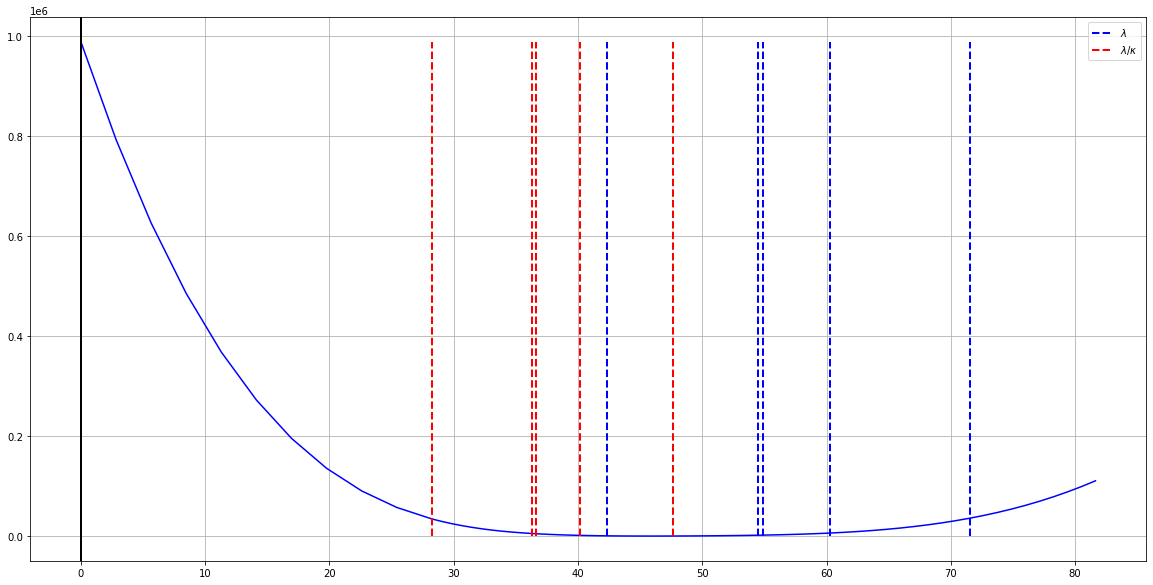

In [6]:
y_max = max(f_values)
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(mu_values, f_values, "b")
ax.axvline(x=0, ymin=0, ymax=y_max, color='k', ls='-', lw=2)
ax.vlines(x=lam, ymin=0, ymax=y_max, colors='b', ls='--', lw=2, label='$\lambda$')
ax.vlines(x=lam / kappa, ymin=0, ymax=y_max, colors='r', ls='--', lw=2, label='$\lambda/\kappa$')
#ax.scatter(mu_minimizer, f_min, color="g", marker="o", s=100)
#ax.scatter(mu_star, f_star, color="m", marker="o", s=200)
#ax.set_xlim([7, 10])
#ax.set_ylim([2000, 2200])
ax.grid(True)
ax.legend();

plt.savefig("secular_p={}.png".format(p))

1.0234948572305247e-09


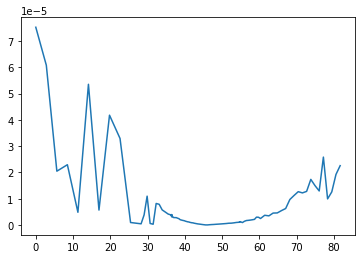

In [7]:
# Gradient check.
fun = lambda x: g.fun(x, p)
grad = lambda x: g.deriv1(x, p)

x_values = mu_values
delta = 1e-6
grad_fd = np.array([(fun(x + delta) - fun(x - delta)) / (2 * delta) for x in x_values])
grad_exact = np.array([grad(x) for x in x_values])
plt.plot(x_values, np.abs(grad_fd - grad_exact))# / np.clip(np.abs(grad_fd), 1e-10, None))
print(norm(grad_fd - grad_exact)/norm(grad_fd))

2.466860155281437e-09


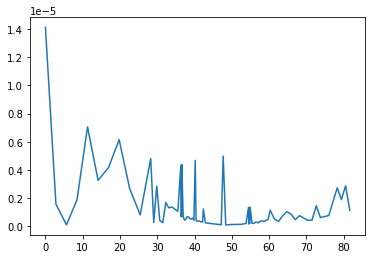

In [8]:
# Gradient check.
fun = lambda x: g.deriv1(x, p)
grad = lambda x: g.deriv2(x, p)

x_values = mu_values
delta = 1e-6
grad_fd = np.array([(fun(x + delta) - fun(x - delta)) / (2 * delta) for x in x_values])
grad_exact = np.array([grad(x) for x in x_values])
plt.plot(x_values, np.abs(grad_fd - grad_exact))# / np.clip(np.abs(grad_fd), 1e-8, None))
print(norm(grad_fd - grad_exact)/norm(grad_fd))

In [9]:
grad_fd - grad_exact

array([ 1.414e-05,  1.562e-06, -9.842e-08,  1.879e-06, -7.057e-06, -3.260e-06,  4.174e-06,  6.152e-06,  2.673e-06,
       -8.067e-07,  4.809e-06, -2.641e-07,  2.848e-06, -4.057e-07, -2.491e-07, -1.684e-06, -1.300e-06, -1.371e-06,
       -1.214e-06, -1.058e-06,  4.328e-06, -7.026e-07, -8.451e-07, -8.738e-07, -7.889e-07, -7.040e-07, -7.327e-07,
       -8.752e-07, -6.766e-07, -8.190e-07,  4.382e-06, -6.934e-07, -4.254e-07, -4.984e-07, -6.851e-07, -6.444e-07,
       -5.469e-07, -5.062e-07, -5.792e-07, -4.249e-07,  4.675e-06, -3.993e-07, -3.575e-07, -3.726e-07, -3.592e-07,
       -3.743e-07, -3.326e-07, -3.192e-07, -3.059e-07, -2.925e-07,  1.227e-06, -2.424e-07, -2.198e-07, -2.114e-07,
       -1.888e-07, -1.733e-07, -1.534e-07, -1.388e-07, -1.233e-07, -9.716e-08,  4.984e-06, -9.201e-08, -1.023e-07,
       -1.198e-07, -1.230e-07, -1.262e-07, -1.295e-07, -1.327e-07, -1.644e-07, -1.960e-07,  1.336e-06, -1.676e-07,
       -1.643e-07, -1.610e-07, -1.862e-07, -2.114e-07, -2.365e-07, -2.333e-07, -

In [10]:
# Add data
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=mu_values, y=f_values, name="$f(\mu)$", mode="lines", line=dict(color='blue', width=1)))
#fig.add_trace(go.Scatter(x=mu_values, y=df_values, name="$f'(\mu)$", mode="lines", line=dict(color='red', width=1)))
# ax.plot(mu_values, g_values, "b")
# ax.axvline(x=0, ymin=0, ymax=y_max, color='k', ls='-', lw=2)
# ax.vlines(x=lam, ymin=0, ymax=y_max, colors='b', ls='--', lw=2, label='$\lambda$')
# ax.vlines(x=lam / kappa, ymin=0, ymax=y_max, colors='r', ls='--', lw=2, label='$\lambda/\kappa$')
# ax.scatter(mu_minimizer, f_min, color="g", marker="o", s=100)
# ax.scatter(mu_star, f_star, color="m", marker="o", s=200)
fig.show()

In [11]:
#p = 1.1
scipy.optimize.minimize_scalar(g.fun, 
                               bracket=(0, merged_endpoints[-1]), 
                               bounds=(0, 0.5 * merged_endpoints[-1], merged_endpoints[-1]), 
                               args=(p, ), method="brent")
#r2 = scipy.optimize.root(g.deriv1, 0.5 * merged_endpoints[-1], args=(p, ))

     fun: 62.91258644842968
    nfev: 17
     nit: 13
 success: True
       x: 45.806329700891325

## Benchmarking

In [12]:
np.random.seed(0)
num_experiments = 10
nfev = []
dim_values = 2 ** np.arange(5, 11)

def tn_nfev(dim, kappa):
    lam = np.sort(100 * np.random.random((dim, )))
    f = tn.TnFunction(lam, kappa)
    result = scipy.optimize.minimize_scalar(f.fun, bracket=(0, f.upper_bound), args=(p,), method="brent")
    assert result.success
    return result.nfev

dim = 100
nfev = max(tn_nfev(dim, kappa) for _ in range(num_experiments))

kappa_values = 10 ** np.arange(10)
dim_values = 2 ** np.arange(5, 10)
p_values = np.array([1, 1.5, 2, 2.5, 5, 10])
nfev = np.array([[[max(tn_nfev(dim, kappa) for _ in range(num_experiments)) 
                   for kappa in kappa_values]
                     for dim in dim_values]
                for p in p_values])

In [13]:
nfev.shape

(6, 5, 10)

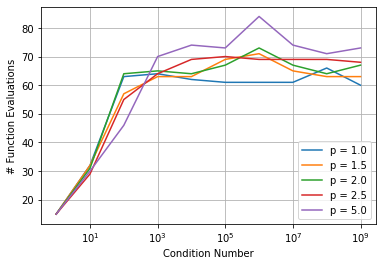

In [21]:
data = nfev[0]
for p, d in zip(p_values, data):
    plt.semilogx(kappa_values, d, label="p = {}".format(p))
plt.xlabel("Condition Number")
plt.ylabel("# Function Evaluations")
plt.grid(True)
plt.legend()
plt.savefig("tn_nfev.png")

In [15]:
def f(x):
    return x ** 2 + np.exp(-x)


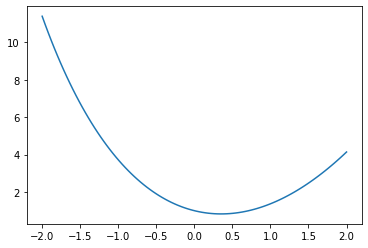

In [16]:
x = np.linspace(-2, 2, 100)
plt.plot(x, f(x))